In [11]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
from scipy import stats
import utils
import seaborn as sns
import pingouin as pg
import matplotlib.cm as cm

import statsmodels.stats.power as smp
from statsmodels.stats.anova import AnovaRM


from natsort import index_natsorted

# plt.rcParams['font.family'] = 'Times New Roman'


path_figs = "./Figs/"

seq_length = 7 #Length of sequences

windowSizes = [1, 2, 3, 7]

fingers = ['1', '2', '3', '4', '5'] #mapping of fingers to numbers

iti = 3000   #Inter trial interval
execTime = 10000 # msecs for each trial maximum
precueTime_interval = [600, 1000] # msecs for planning before movement 
hand = 2 #left or right hand

# total_sub_num = 10
sub_nums = [1, 2, 3, 4, 5, 6, 7]

num_blocks_per_session = 12
num_trials_per_block = 24
num_trails_per_cond = 8

session1_blocks = [_ for _ in range(1, num_blocks_per_session+1)]
session2_blocks = [_ for _ in range(num_blocks_per_session+1, 2*num_blocks_per_session+1)]
session3_blocks = [_ for _ in range(2*num_blocks_per_session+1, 3*num_blocks_per_session+1)]
session4_blocks = [_ for _ in range(3*num_blocks_per_session+1, 4*num_blocks_per_session+2)]


In [12]:
subjs_list = utils.read_dat_files_subjs_list(sub_nums)

for subj in subjs_list: ###Adding IPIs
    utils.add_IPI(subj)

subjs = pd.concat(subjs_list) ###Merging all subjs into one dataframe
subjs.reset_index(inplace=True, drop=True)

subjs_presses = utils.finger_melt(subjs).rename(columns={'isError' : 'isTrialError'})

subjs['condition'] = subjs.apply(utils.seq_condition, axis=1)
subjs_presses['condition'] = subjs_presses.apply(utils.seq_condition, axis=1)

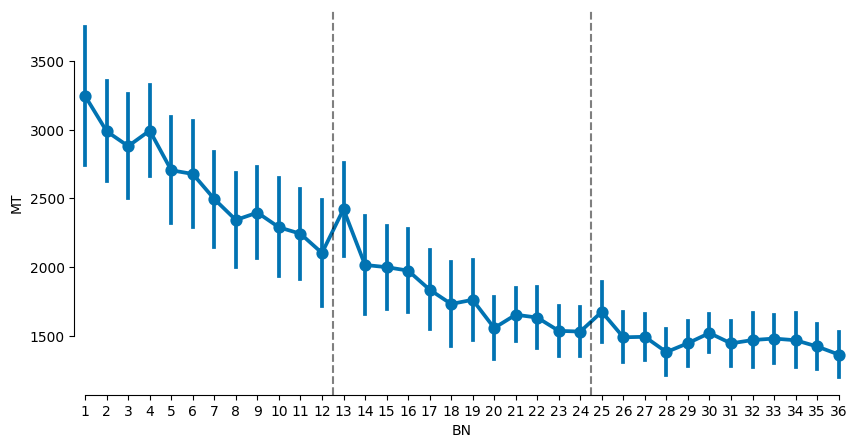

In [20]:
plt.figure(figsize=(10, 5))
subjs_correct = utils.remove_error_trials(subjs)

subjs_grouped = subjs_correct.groupby(['BN', 'SubNum']).agg({
    'MT': 'median'
}).reset_index()

sns.pointplot(data = subjs_grouped, x = 'BN', y = 'MT', errorbar='se', hue = 0,
              palette='colorblind', legend=False)
plt.axvline(x=11.5, color='black', linestyle='--', alpha = 0.5)
plt.axvline(x=23.5, color='black', linestyle='--', alpha = 0.5)
sns.despine(trim=True)

plt.show()

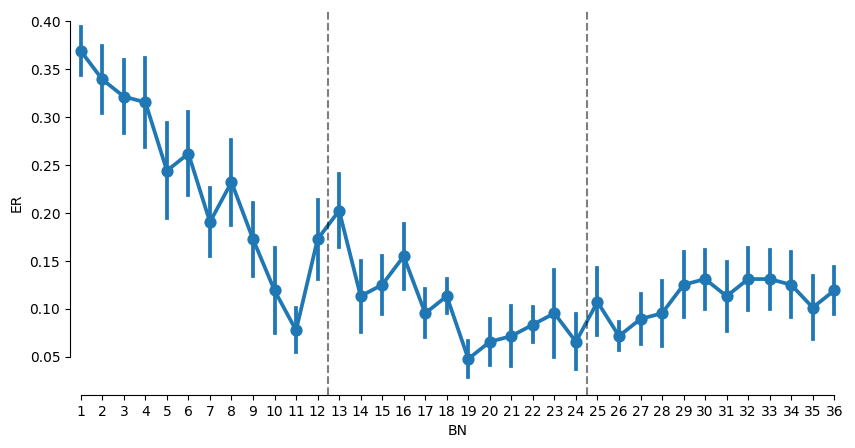

In [21]:
plt.figure(figsize=(10, 5))

subjs_grouped = subjs.groupby(['BN', 'SubNum']).agg({
    'isError': 'sum'
}).reset_index()

subjs_grouped['ER'] = subjs_grouped['isError']/ num_trials_per_block 

sns.pointplot(data = subjs_grouped, x = 'BN', y = 'ER', hue =0, errorbar='se', legend=False)
plt.axvline(x=11.5, color='black', linestyle='--', alpha = 0.5)
plt.axvline(x=23.5, color='black', linestyle='--', alpha = 0.5)
sns.despine(trim=True)

plt.show()

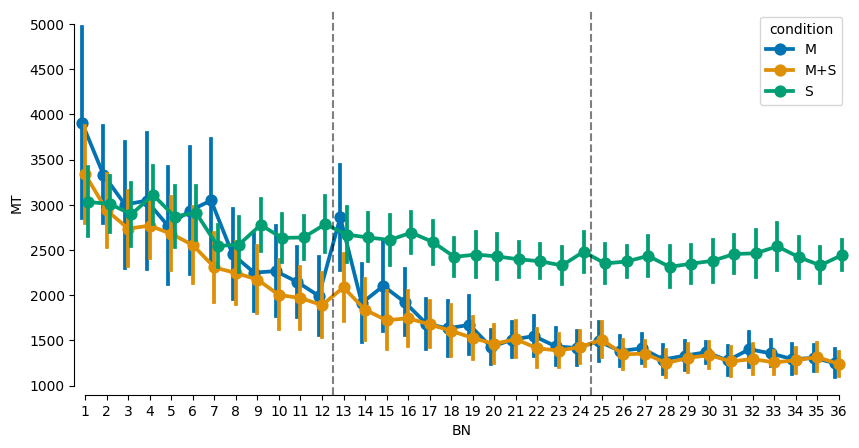

In [22]:
plt.figure(figsize=(10, 5))

subjs_correct = utils.remove_error_trials(subjs)

subjs_grouped = subjs_correct.groupby(['BN', 'SubNum', 'condition']).agg({
    'MT': 'median'
}).reset_index()

sns.pointplot(data = subjs_grouped, x = 'BN', y = 'MT', hue = 'condition', errorbar='se',
              dodge = 0.3, palette='colorblind')
plt.axvline(x=11.5, color='black', linestyle='--', alpha = 0.5)
plt.axvline(x=23.5, color='black', linestyle='--', alpha = 0.5)
sns.despine(trim=True)

plt.show()

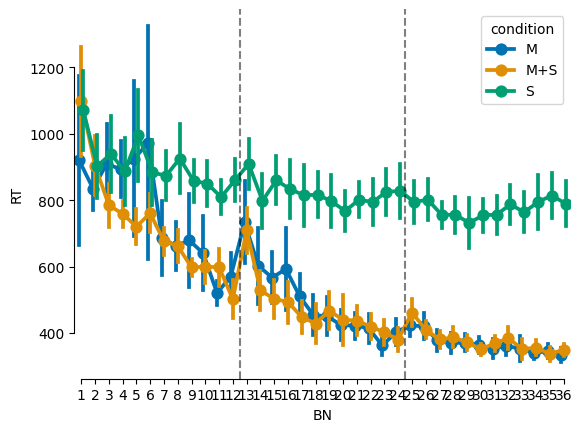

In [23]:
subjs_correct = utils.remove_error_trials(subjs)

subjs_grouped = subjs_correct.groupby(['BN', 'SubNum', 'condition']).agg({
    'RT': 'median'
}).reset_index()

sns.pointplot(data = subjs_grouped, x = 'BN', y = 'RT', hue = 'condition', errorbar='se',
              dodge = 0.3, palette='colorblind')
plt.axvline(x=11.5, color='black', linestyle='--', alpha = 0.5)
plt.axvline(x=23.5, color='black', linestyle='--', alpha = 0.5)
sns.despine(trim=True)

plt.show()

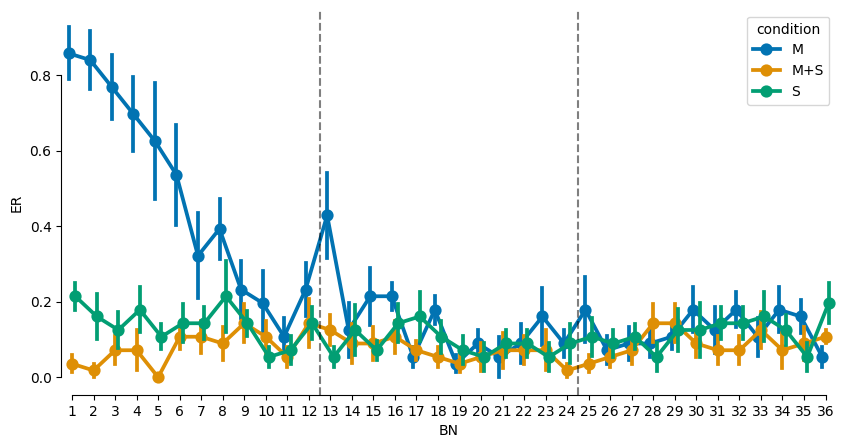

In [25]:
plt.figure(figsize=(10, 5))
subjs_grouped = subjs.groupby(['BN', 'SubNum', 'condition']).agg({
    'isError': 'sum'
}).reset_index()

subjs_grouped['ER'] = subjs_grouped['isError']/ num_trails_per_cond 

sns.pointplot(data = subjs_grouped, x = 'BN', y = 'ER', hue ='condition', 
              errorbar='se', dodge = 0.3, palette='colorblind')
plt.axvline(x=11.5, color='black', linestyle='--', alpha = 0.5)
plt.axvline(x=23.5, color='black', linestyle='--', alpha = 0.5)
sns.despine(trim=True)

plt.show()

### Horizon Effect:

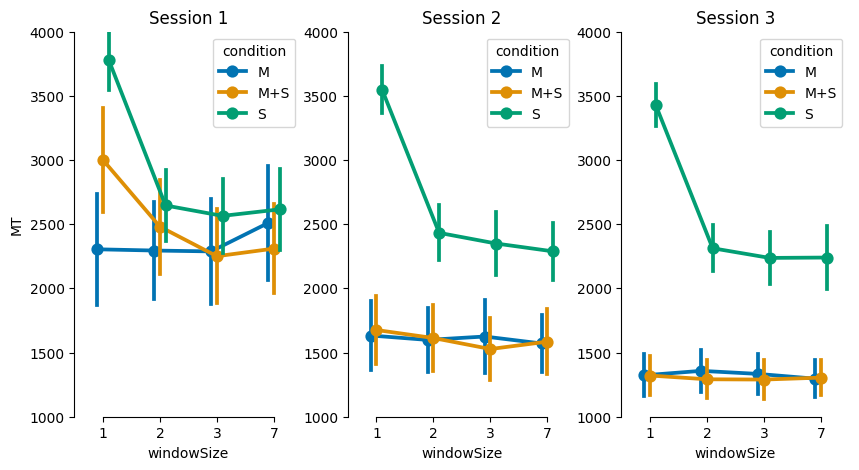

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
for idx, session in enumerate([session1_blocks, session2_blocks, session3_blocks]):
    subjs_sess = subjs[subjs['BN'].isin(session)]
    subjs_correct = utils.remove_error_trials(subjs_sess)

    subjs_grouped = subjs_correct.groupby(['SubNum', 'condition', 'windowSize']).agg({
        'MT': 'median'
    }).reset_index()

    sns.pointplot(data = subjs_grouped, x = 'windowSize', y = 'MT', hue = 'condition', errorbar='se',
                dodge = 0.2, palette='colorblind', ax = axs[idx])
    if idx >0:
        axs[idx].set_ylabel('')

    axs[idx].set_ylim(1000, 4000)
    axs[idx].set_title(f'Session {idx+1}')
sns.despine(trim=True)

plt.show()

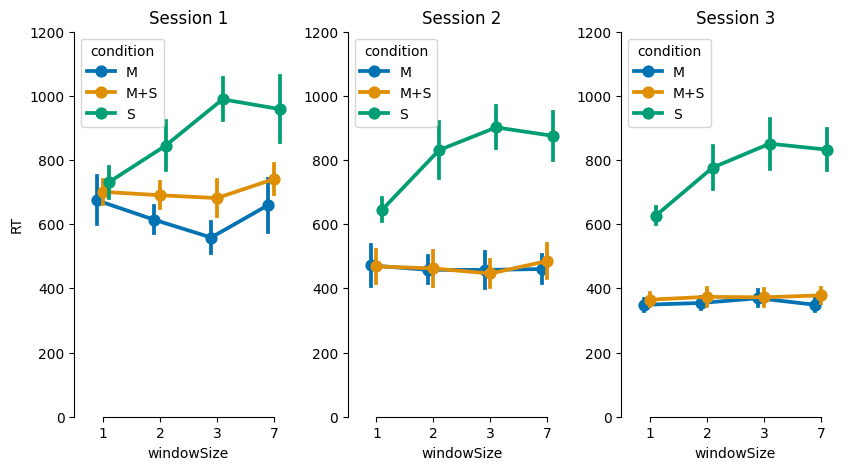

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
for idx, session in enumerate([session1_blocks, session2_blocks, session3_blocks]):
    subjs_sess = subjs[subjs['BN'].isin(session)]
    subjs_correct = utils.remove_error_trials(subjs_sess)

    subjs_grouped = subjs_correct.groupby(['SubNum', 'condition', 'windowSize']).agg({
        'RT': 'median'
    }).reset_index()

    sns.pointplot(data = subjs_grouped, x = 'windowSize', y = 'RT', hue = 'condition', errorbar='se',
                dodge = 0.2, palette='colorblind', ax = axs[idx])
    if idx >0:
        axs[idx].set_ylabel('')

    axs[idx].set_ylim(0, 1200)
    axs[idx].set_title(f'Session {idx+1}')
sns.despine(trim=True)

plt.show()

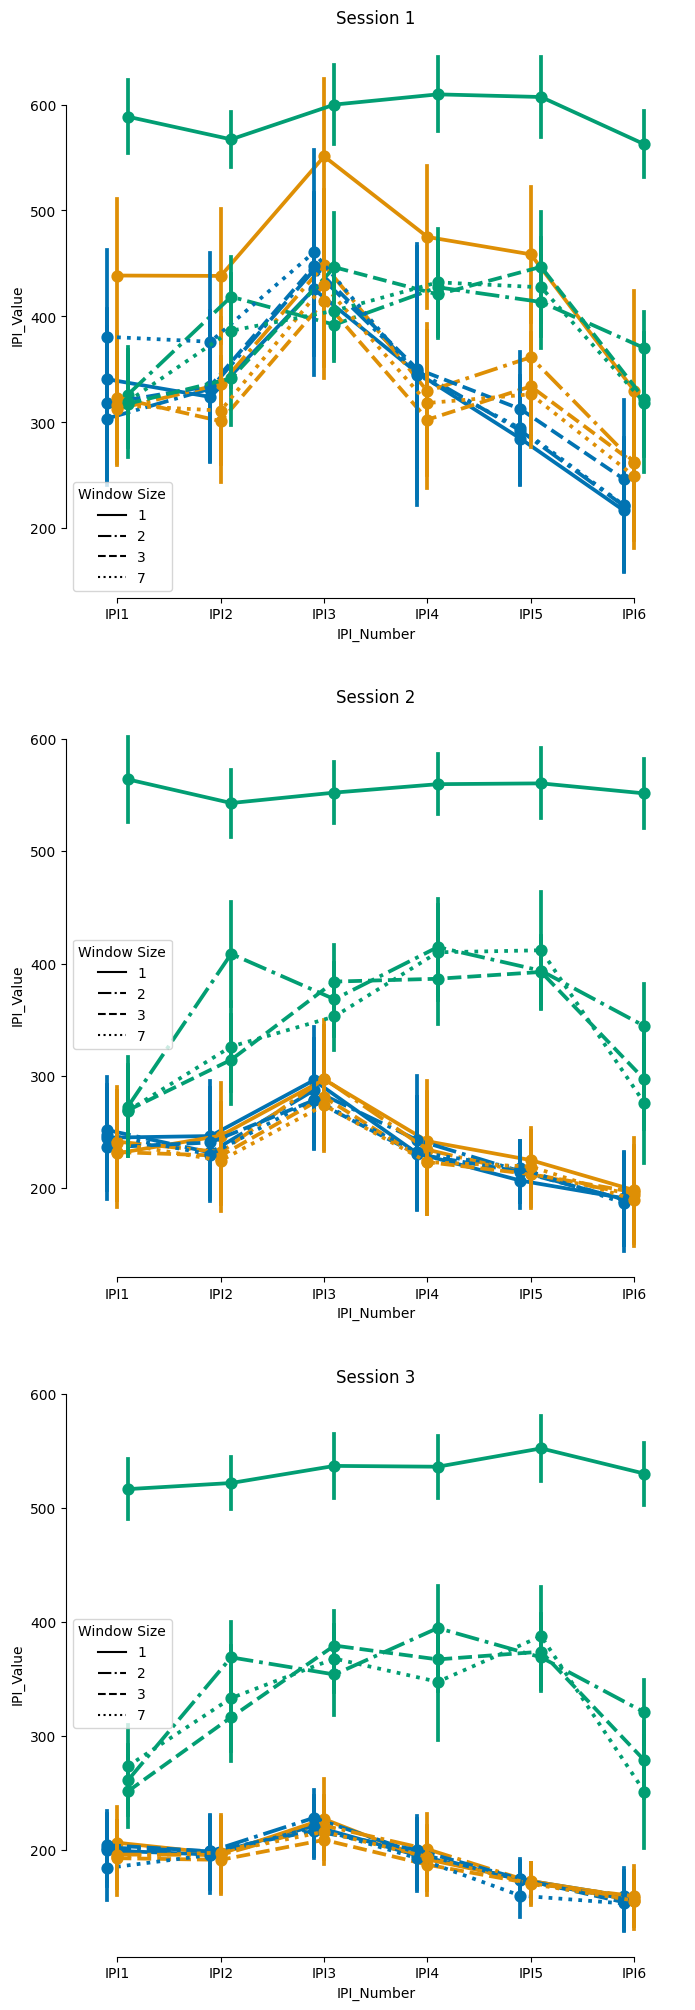

In [79]:
fig, axs = plt.subplots(3, 1, figsize=(8, 25))
line_styles = ['solid', 'dashdot', 'dashed', 'dotted']
for idx, session in enumerate([session1_blocks, session2_blocks, session3_blocks]):
    subjs_sess = subjs_presses[subjs_presses['BN'].isin(session)]
    subjs_correct = utils.remove_error_trials_presses(subjs_sess)

    subjs_grouped = subjs_correct.groupby(['SubNum', 'condition', 'windowSize', 'IPI_Number']).agg({
        'IPI_Value': 'median'
    }).reset_index()

    for window_idx, window in enumerate(windowSizes):
        subjs_grouped_window = subjs_grouped[subjs_grouped['windowSize'] == window]
        sns.pointplot(data = subjs_grouped_window, x = 'IPI_Number', y = 'IPI_Value', hue = 'condition', errorbar='se',
                    dodge = 0.2, palette='colorblind', ax = axs[idx], linestyles=line_styles[window_idx], legend=False)
        
    #create custom legend for the line styles
    custom_lines = [plt.Line2D([0], [0], color='black', linestyle=line_styles[0]),
                    plt.Line2D([0], [0], color='black', linestyle=line_styles[1]),
                    plt.Line2D([0], [0], color='black', linestyle=line_styles[2]),
                    plt.Line2D([0], [0], color='black', linestyle=line_styles[3])]
    axs[idx].legend(custom_lines, windowSizes, title='Window Size')
    
        

    

#     if idx >0:
#         axs[idx].set_ylabel('')

#     axs[idx].set_ylim(1000, 4000)
    axs[idx].set_title(f'Session {idx+1}')
sns.despine(trim=True)

# plt.show()